In [17]:
import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.readwrite import json_graph

In [18]:
data = pd.read_csv("./data/data_scopus.csv")
columns_to_remove = ['Abstract', 'Conference name', 'Conference date', 'Abbreviated Source Title']
data.drop(columns=columns_to_remove, inplace=True)
data = data[~pd.isnull(data['Authors'])].copy()
data = data[~pd.isnull(data['Authors with affiliations'])].copy()
data = data[~pd.isnull(data['Year'])].copy()
data = data[~pd.isnull(data['Publisher'])].copy()
data['Cited by'].fillna(0.0, inplace=True)
data.head(2)

,Title,Year,EID,Publisher,Authors,Author(s) ID,Authors with affiliations,Source title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,Elsevier B.V.,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,0.0
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,Academic Press,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,0.0


In [19]:
def get_first_author_affilation(x):
  try:
    countries = []
    affiliations = x.split(";")
    for aff in affiliations:
      countries.append(aff.split(",")[-1].strip())
    my_string = ','.join(map(str, countries))
    return my_string
  except Exception as ex:
    print(x)

data['Author_Countries']=data['Authors with affiliations'].apply(get_first_author_affilation)
data.head()

,Title,Year,EID,Publisher,Authors,Author(s) ID,Authors with affiliations,Source title,Cited by,Author_Countries
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,Elsevier B.V.,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,0.0,"Canada,United States,Canada,Canada"
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,Academic Press,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,0.0,"Italy,Italy"
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Elsevier B.V.,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,0.0,"Serbia,Germany,Germany,Germany,Serbia,Germany"
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Springer,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,0.0,"Japan,Japan,Japan,Australia,Australia"
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Academic Press Inc.,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,0.0,"India,India,India"


In [20]:
set_countries = set()
for index,row in data.iterrows():
    for i in row['Author_Countries'].split(","):
        set_countries.add(i)
set_countries

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Ecuador',
 'Egypt',
 'Finland',
 'France',
 'Gabon',
 'Germany',
 'Greece',
 'Hong Kong',
 'Hungary',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Italy',
 'Japan',
 'Kazakhstan',
 'Lebanon',
 'Netherlands',
 'Norway',
 'Pakistan',
 'Philippines',
 'Poland',
 'Polytechnic Univ',
 'Portugal',
 'Qatar',
 'Romania',
 'Russian Federation',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Trinidad and Tobago',
 'Tunisia',
 'Turkey',
 'United Kingdom',
 'United States',
 'Univ of Massachusetts at Lowell',
 'Visible Decisions Inc'}

In [21]:
# Create a graph
G = nx.Graph()

# Dictionary to store nodes with author_id as the key
nodes_dict = {}

# Iterate through the DataFrame
for index, row in data.iterrows():
    author_ids = row['Author(s) ID'].split(';')
    countries = row['Author_Countries'].split(',')
    names = row['Authors'].split(',')
    i = -1
    for author_id in author_ids:
        if author_id not in nodes_dict:
            nodes_dict[author_id] = {
                # "publications": [],
                "Name": names[i].strip(),
                "country": countries[i],
                "num_publications": 0,
                "num_citations": 0,
                "degree": 0,
                "id": author_id
            }
        # publication_info = {
        #     row['EID']: {
        #         "Title": row['Title'],
        #         "Year": row['Year'],
        #         "Citations": row['Cited by'],
        #         "Publisher": row['Publisher'],
        #     }
        # }
        i = i + 1

        # Append new publication information to the existing publications list
        # nodes_dict[author_id]["publications"].append(publication_info)
        nodes_dict[author_id]["num_publications"] += 1
        nodes_dict[author_id]["num_citations"] += row['Cited by']
        nodes_dict[author_id]["degree"] += len(author_ids) - 1

# Convert the dictionary values to a list
nodes = list(nodes_dict.values())

# Print or use the 'nodes' list as needed
# print(nodes)


In [22]:
for node in nodes:
    G.add_node(node["id"], **node)

# print(G.nodes(data=True))


In [23]:
edges = []

for _, row in data.iterrows():
    if ";" in row['Author(s) ID']:
        authors = row['Author(s) ID'][:-1].split(";")
        for i, author1 in enumerate(authors):
            for j in range(i + 1, len(authors)):
                edges.append((author1, authors[j]))
    else:
        continue

In [24]:
G.add_edges_from(edges)
# print(G.edges(data=True))

print(G)

Graph with 986 nodes and 1913 edges


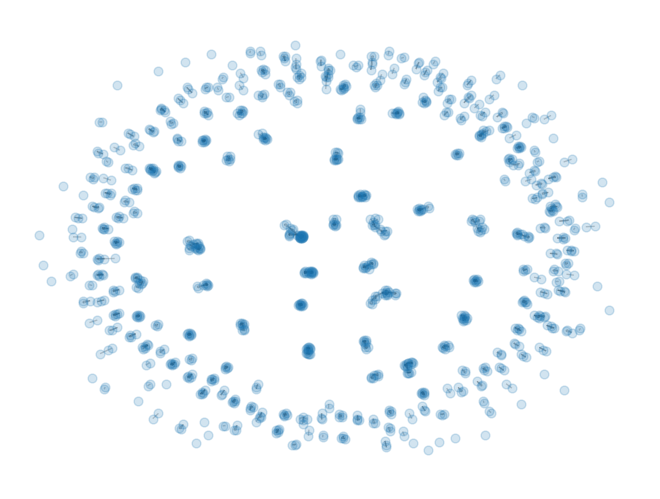

In [25]:

# # Visualize the co-authorship network
# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(G, k=0.15)  # You can use different layout algorithms
# nx.draw(G, pos, node_size=10, node_color='b', alpha=0.6, with_labels=False)
# plt.title('Co-Authorship Network')
# plt.show()

pos = nx.spring_layout(G)
nx.draw(G,pos=pos, node_size=40,alpha=.2)

In [26]:
with open("./data/publication_network.json",'w') as f:
  json.dump(json_graph.node_link_data(G),f)

In [27]:
# G = nx.relabel.convert_node_labels_to_integers(G, first_label=1, ordering="default", label_attribute=None)
nx.write_gml(G,"network.gml")